[]

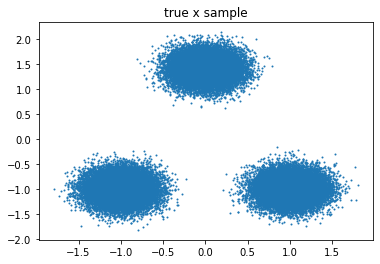

In [81]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        _data = np.random.randn(n_data, 2)
        mu = [[1.0, -1.0], [0, 1.0], [-1.0, -1.0]]
        sig = [[0.2, 0.2], [0.2, 0.2], [0.2, 0.2]]
        for i in range(n_data):
            _data[i][0] = sig[i % 3][0] * _data[i][0] + mu[i % 3][0]
            _data[i][1] = sig[i % 3][1] * _data[i][1] + mu[i % 3][1]

        self.data = torch.from_numpy(_data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]

dataset = CustomDataSet(60000)
sample_data = dataset.data.numpy()
plt.title('true x sample')
plt.scatter(sample_data[:, 0], sample_data[:, 1], s=1)
plt.plot()

In [0]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=2, bias=True)
        )


    def forward(self, x):
        return self.layer(x)


class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=2, bias=True)
        )


    def forward(self, x):
        return self.layer(x)


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)


def nll_evidence_loss(_mu, _target):
    _nll = (_mu - _target) * (_mu - _target)
    return _nll.mean()


def gaussian_sampling(_mu, _stddev):
    _eps = torch.FloatTensor(_stddev.size()).normal_()
    return _stddev * _eps + _mu

In [0]:
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
discriminator = Discriminator()
encoder = Encoder()
decoder = Decoder()
discriminator_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=0.001)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=0.001)

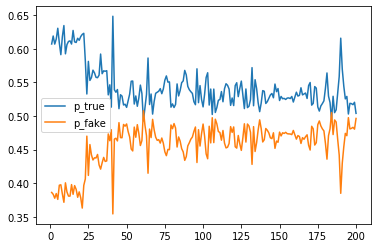

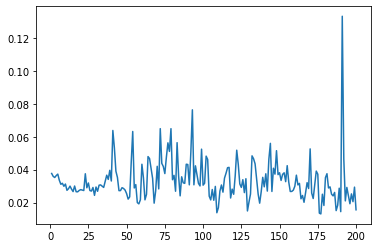

In [88]:
num_epochs = 200
recon_loss = []
discriminator_p_real = []
discriminator_p_fake = []
for epoch in range(num_epochs):
    avg_recon_loss = 0.0
    avg_p_real = 0.0
    avg_p_fake = 0.0
    for batch_index, mini_batch_data in enumerate(loader):
        discriminator_optimizer.zero_grad()
        p_real = discriminator(torch.randn(batch_size, 2))
        p_fake = discriminator(encoder(mini_batch_data))
        discriminator_loss = (-torch.log(p_real) - torch.log(1.0 - p_fake)).mean()
        discriminator_loss.backward()
        discriminator_optimizer.step()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        z = encoder(mini_batch_data)
        x = decoder(z)
        adversarial_training_loss = (-torch.log(discriminator(z))).mean()
        evidence_nll_loss = nll_evidence_loss(x, mini_batch_data)
        encoder_decoder_loss = (evidence_nll_loss + adversarial_training_loss)
        encoder_decoder_loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        
        avg_recon_loss += evidence_nll_loss.item()
        avg_p_real += p_real.mean().item()
        avg_p_fake += p_fake.mean().item()
    recon_loss.append(avg_recon_loss/len(loader))
    discriminator_p_real.append(avg_p_real/len(loader))
    discriminator_p_fake.append(avg_p_fake/len(loader))

plt.plot(np.arange(1, len(discriminator_p_real) + 1), discriminator_p_real, label='p_true')
plt.plot(np.arange(1, len(discriminator_p_fake) + 1), discriminator_p_fake, label='p_fake')
plt.legend()
plt.show()
plt.plot(np.arange(1, len(recon_loss) + 1), recon_loss, label='reconstruction loss')
plt.legend()
plt.show()

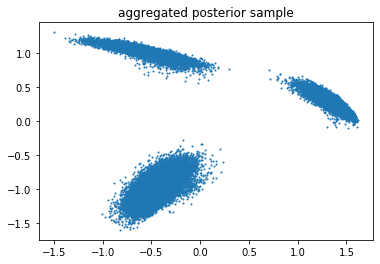

In [93]:
z_sample = encoder(torch.FloatTensor(dataset.data))
x_sample = decoder(z_sample)
plt.title('aggregated posterior sample')
plt.scatter(z_sample.data.numpy()[:, 0], z_sample.data.numpy()[:, 1], s=1)
plt.show()

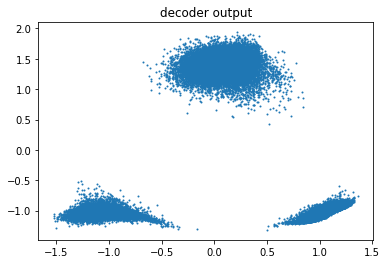

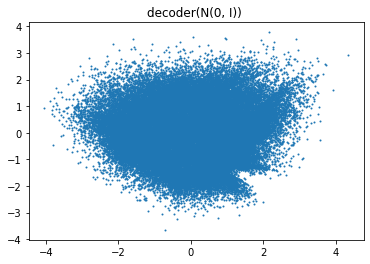

In [94]:
plt.title('decoder output')
plt.scatter(x_sample.data.numpy()[:, 0], x_sample.data.numpy()[:, 1], s=1)
plt.show()

x_sample = decoder(torch.randn(60000, 2))
plt.title('decoder(N(0, I)) ')
plt.scatter(x_sample.data.numpy()[:, 0], x_sample.data.numpy()[:, 1], s=1)
plt.show()